In [34]:
from src.pyssla_designer.config import config

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
from PIL import Image
import cv2

import math
from collections import Counter

In [36]:
image_path = 'images/square_images/eighty_six.webp'
# image_path = 'images/haikyuu.png'

img = Image.open(image_path)
img_array = np.array(img)

In [37]:
if img_array.shape[-1] > 3:
    img_array = img_array[:, :, :3]

In [38]:
def init_config(canvas_multiplier=1):
    canvas_side = config['CANVAS_SIDE'] * canvas_multiplier
    colors = [config['WHITE'], config['BLACK'], config['BROWN'], config['RED'], config['ORANGE'],
              config['YELLOW'], config['GREEN'], config['BLUE'], config['PURPLE'], config['PINK']]
    color_names = ['white', 'black', 'brown', 'red', 'orange',
                   'yellow', 'green', 'blue', 'purple', 'pink']

    return canvas_side, colors, color_names

side_length, colors, color_names = init_config(canvas_multiplier=4)

assert len(colors) == len(color_names)
hex_to_name = {colors[i]: color_names[i] for i in range(len(colors))}

canvas_size = (side_length, side_length) # use a square canvas for now
# canvas_size = (3 * side_length, 2 * side_length)
canvas_size

(116, 116)

In [39]:
import inspect
import src.pyssla_designer.downsampling as downsampling

downsampling_functions = [(name, obj) for name, obj in inspect.getmembers(downsampling, inspect.isfunction)]
print([func[0] for func in downsampling_functions])

['claude_downscale_averaging', 'claude_downscale_convolution', 'claude_downscale_mean', 'claude_downscale_nearest_neighbor', 'gemini_downscale_median_pooling', 'gemini_downscale_mode_pooling', 'gemini_downscale_opencv_nearest', 'gemini_downscale_pre_sharpened_nearest']


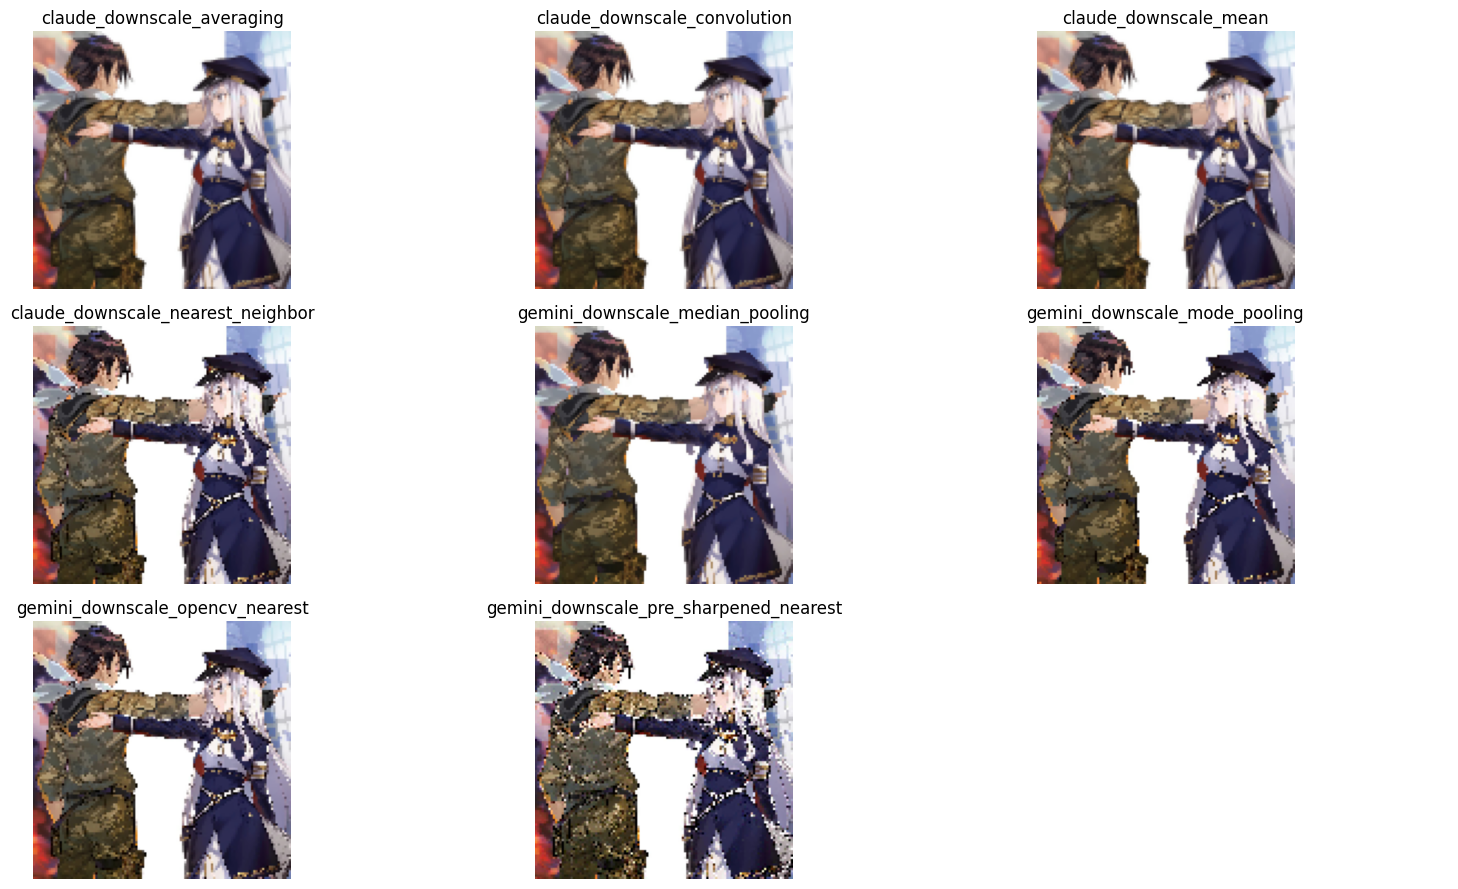

In [40]:
num_functions = len(downsampling_functions)
num_cols = 3
num_rows = math.ceil(num_functions / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 9))
axes = axes.flatten()

for ax_idx in range(num_functions):
    func_name, func = downsampling_functions[ax_idx]
    axes[ax_idx].imshow(func(img_array, canvas_size))
    axes[ax_idx].set_title(func_name)
    axes[ax_idx].axis('off')

for i in range(ax_idx, num_cols * num_rows):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [41]:
def quantize_to_palette(image_array, colors):
    palette = np.array([hex_to_rgb(c) for c in colors], dtype=np.float32)
    
    h, w, _ = image_array.shape
    pixels = image_array.reshape(-1, 3).astype(np.float32)
    
    distances = np.sqrt(np.sum((pixels[:, np.newaxis] - palette) ** 2, axis=2))
    
    closest_indices = np.argmin(distances, axis=1)
    
    quantized_pixels = palette[closest_indices]
    
    return quantized_pixels.reshape(h, w, 3).astype(np.uint8)

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

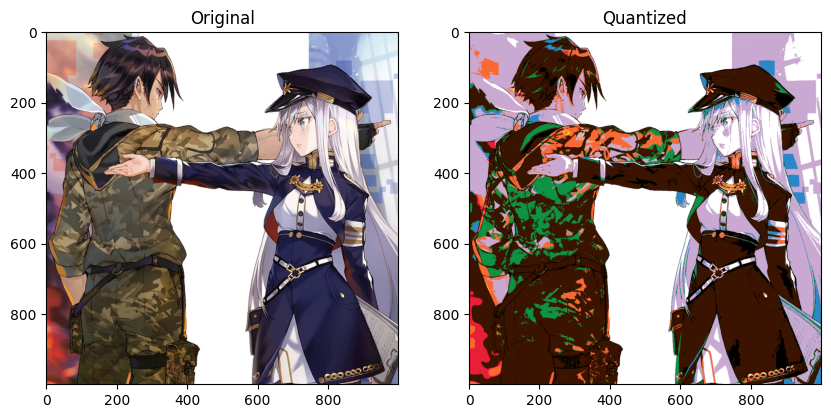

In [42]:
quantized_array = quantize_to_palette(img_array, colors)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_array), plt.title("Original")
plt.subplot(122), plt.imshow(quantized_array), plt.title("Quantized")
plt.show()

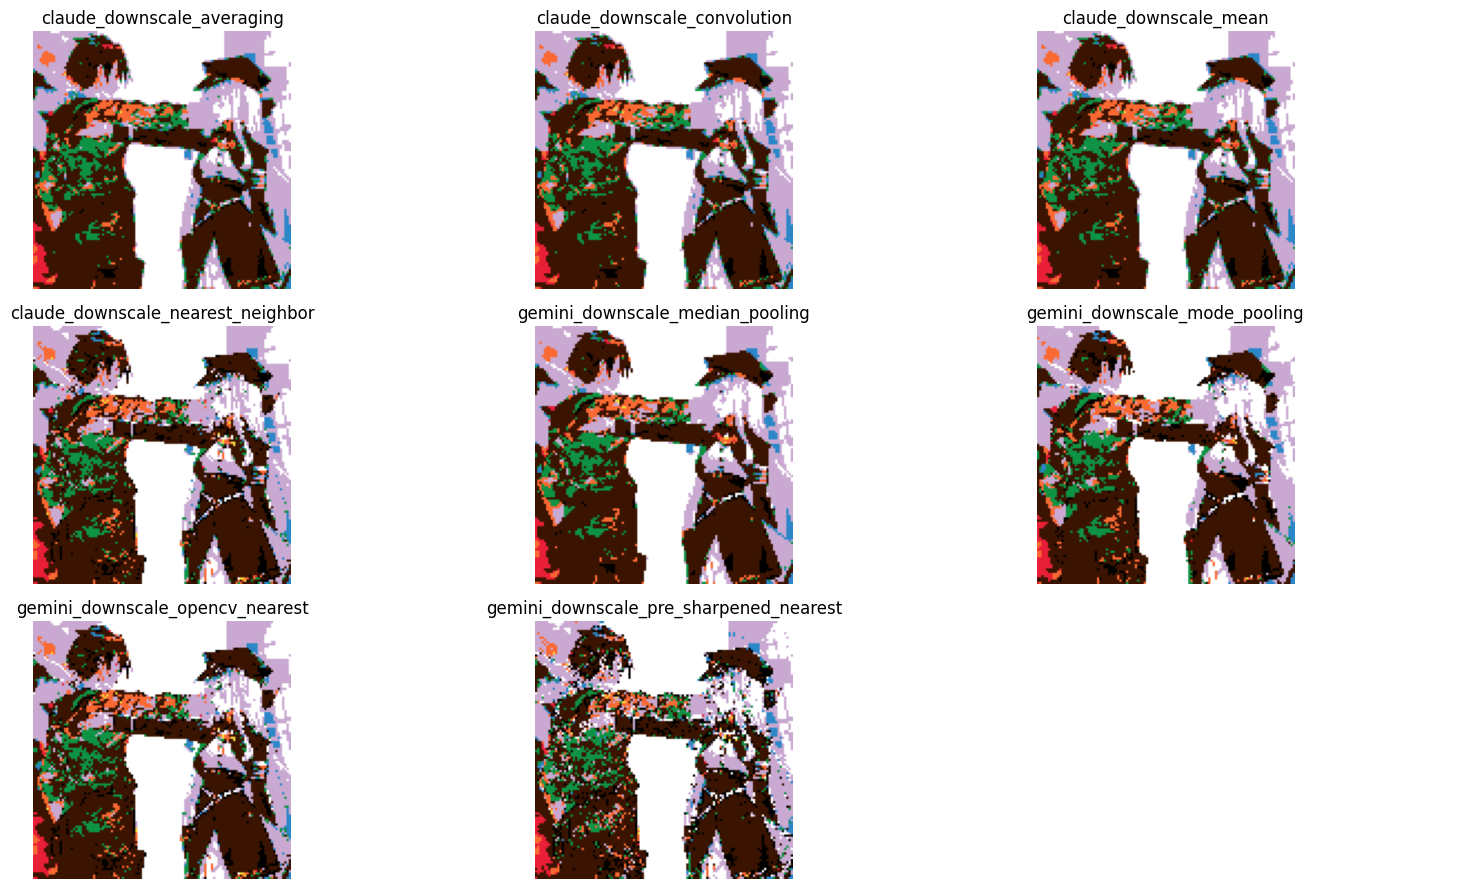

In [43]:
num_functions = len(downsampling_functions)
num_cols = 3
num_rows = math.ceil(num_functions / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 9))
axes = axes.flatten()

for ax_idx in range(num_functions):
    func_name, func = downsampling_functions[ax_idx]
    downsized_array = func(img_array, canvas_size)
    quantized_array = quantize_to_palette(downsized_array, colors)

    axes[ax_idx].imshow(quantized_array)
    axes[ax_idx].set_title(func_name)
    axes[ax_idx].axis('off')

for i in range(ax_idx, num_cols * num_rows):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

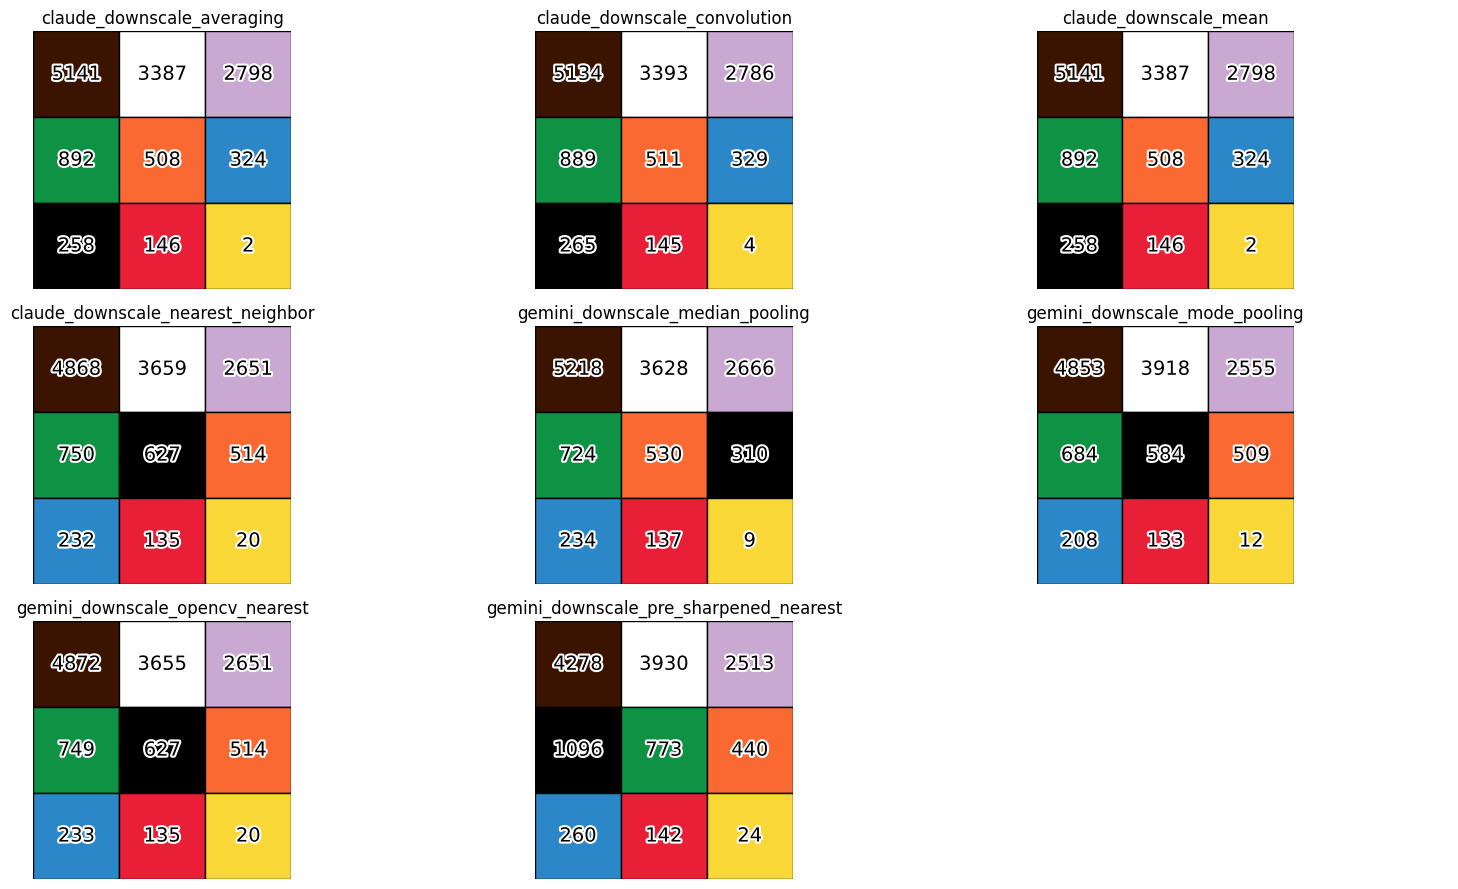

In [44]:
def get_color_info(quantized_array):
    pixels = quantized_array.reshape(-1, 3)
    unique_colors, counts = np.unique(pixels, axis=0, return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]

    colors, color_counts = [], []

    for idx in sorted_indices[:9]:
        color = unique_colors[idx]
        hex_color = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
        colors.append(hex_color)
        color_counts.append(counts[idx].item())

    return colors, color_counts

def plot_custom_matrix(ax, numbers, colors):
    if len(numbers) != 9 or len(colors) != 9:
        raise ValueError("Both 'numbers' and 'colors' must have exactly 9 elements.")
    
    matrix_numbers = np.array(numbers).reshape(3, 3)
    matrix_colors = np.array(colors).reshape(3, 3)
    
    ax.set_xticks([])
    ax.set_yticks([])

    for i in range(3):
        for j in range(3):
            rect = plt.Rectangle((j, i), 1, 1, facecolor=matrix_colors[i, j], edgecolor='black')
            ax.add_patch(rect)
            # ax.text(j + 0.5, i + 0.5, str(matrix_numbers[i, j]),
            #         ha='center', va='center', fontsize=14, color='black')
            text = ax.text(j + 0.5, i + 0.5, str(matrix_numbers[i, j]),
                         ha='center', va='center', fontsize=14, color='black',
                         path_effects=[
                             patheffects.withStroke(linewidth=3, foreground='white')
                         ])
    
    ax.set_xlim(0, 3)
    ax.set_ylim(3, 0)
    
    ax.set_aspect('equal')

num_functions = len(downsampling_functions)
num_cols = 3
num_rows = math.ceil(num_functions / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 9))
axes = axes.flatten()

for ax_idx in range(num_functions):
    func_name, func = downsampling_functions[ax_idx]
    downsized_array = func(img_array, canvas_size)
    quantized_array = quantize_to_palette(downsized_array, colors)

    quantized_colors, quantized_numbers = get_color_info(quantized_array)

    if len(quantized_colors) == len(quantized_numbers) and 0 < len(quantized_numbers) < 9:
        quantized_colors.extend(['#ffffff'] * (9 - len(quantized_colors)))
        quantized_numbers.extend([''] * (9 - len(quantized_numbers)))

    plot_custom_matrix(axes[ax_idx], quantized_numbers, quantized_colors)

    axes[ax_idx].set_title(func_name)
    axes[ax_idx].axis('off')

for i in range(ax_idx, num_cols * num_rows):
    axes[i].axis('off')

plt.tight_layout()
plt.show()